# Data Analysis: Group Fairness for Social Media Influencers

This notebook contains the code for the data analysis presented in "Group Fairness for Content Creators: the Role of Human and Algorithmic Biases under Popularity-based Recommendations" publish within the Proceedings of the 17th ACM Conference on Recommender Systems (RecSys 2023). As already mentioned in the ReadMe file, this code assumes data already exists in the Simulation_results folder. If this is not the case, please reeturn to the ReadMe file for further instructures on how to generate the dataset.

Below, we import the neede libraries. Please ensure they are installed.

In [1]:
import simulation as sim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import ast

Next, we construct a function which reads the config files of multiple simulations. We use this function to create a list of the simulations within the 'Simulation_results' folder. This will be later used for the analysis. For improving the run-time we only load the results of the simulations when needed.

In [2]:
def read_sims(no, first_sim=0, path='Simulation_results/'):
    '''Constructs simulations for no many previously run ones.
    
    Input
    ------
    no: int
       The number of config files to load
    first_sim: int
       The first config number which should be loaded
    pat: string
       The folder where the config and run files are
    ------
    
    Output
    ------
    all_sims: list
        A list of Simulations objects which have config file loaded (but, for better runtime, not the results)
    ------
    '''

    # start with an empty list
    all_sims = []
    
    # loop over config numbers in the specified range
    for n in range(first_sim, first_sim + no):
        # build the Simulation object for the config with that number
        s = sim.Simulation(path + 'config' + str(n) + '.csv')
        
        # read the config file values (to save time, we only read the results of a simulation when needed)
        s.read(False)
        
        # add the Simulation object to our list
        all_sims.append(s)

    return all_sims

In [3]:
sims = read_sims(112500)

## Auxiliary functions for creating the plots

### General-purpose auxiliary funcitons

First we define a function that based on the list with the number of followers for content creators orderd from best-quality (position 0) to lowest-quality (last position) returns the same-size binary list. More precisely, the list will have on each position 0 if the input popularity list does is not individually fair for the respective content creator. Similarly, 1 will be used to signal individual fairness for the respective content creator.

In [4]:
def get_if_IF(popularity):
    '''Given a list of follower counts for content creators in the order of their 
    quality finds if each is treated fairly.
    
    Input
    ------
    popularity: list
       List of nonegative integers corresponding to follower counts for each creator
    ------
    
    Output
    ------
    is_fair: list
        A list of 0/1 of the same length as the input.
    ------   
    '''
    
    # find the number of content creators
    num_CCs = len(popularity)

    # get the inexes of CCs by the number of followers
    popularity = np.array(popularity)
    ordered_by_popualrity = np.flip(popularity.argsort())
    id_to_position_popualrity = {i:pos for pos, i in enumerate(ordered_by_popualrity)}

    # find if fair (CC_i is in terms of popularity on the position it deserves or more twoards the top)
    def is_fair(i):
        return int(id_to_position_popualrity[i] <= i)
    
    # return a vector of 0s and 1s depending on whether CC_i (i-th best CC) was treated fairly
    return [is_fair(i) for i in range(num_CCs)]

Some of the plots (e.g., Figure 2) require separating the content creators of a given type (protected or unprotected) into subgroups based on their relative positioning quality-wise. Thus we define a function creating different types of partitioning. For each type of partition (specified by cl) the funciton generates a label, a lambda function which selects the CCs at the respective position given an ordered vector, and the colour with which they will be represented. 

In [5]:
def make_labels_and_functions(group = 'protected', cl = '-'):
    '''
    Function generating the labels, lamba functions, and colours corresponding to each tier of content creators.
    
    Input
    ------
    group: string
        The type of users considered (protected/unprotected) 
    cl: string
        Gives the group for which we want to generate the information.
    ------
    
    Output
    ------
    preposition: tuple
        The label for the given group and the lambda function for selecting the respective CCs from a vector
    color: string
        The code corresponding to the color to be used for the respective group
    ------
    '''
    
    # we take in turn different tiers  of content creators and generate the preposition and weight of color
    if cl == '1':
        preposition = ('best ', lambda CCs_by_quality: CCs_by_quality[0:1])
        weight = 0.8*0.15
    if cl == '-50%':
        preposition = ('top 50% ', lambda CCs_by_quality: CCs_by_quality[:int((len(CCs_by_quality))/2)])
        weight = 0.8*0.15
    if cl == '-33%':
        preposition = ('top 33% ', lambda CCs_by_quality: CCs_by_quality[:int((len(CCs_by_quality))/3)])
        weight = 0.8*0.15
    if cl == '2-50%':
        preposition = ('remaining top 50% ', lambda CCs_by_quality: CCs_by_quality[1:int((len(CCs_by_quality))/2)])
        weight = 0.8*0.3
    if cl == '2-25%':
        preposition = ('remaining top 25% ', lambda CCs_by_quality: CCs_by_quality[1:int((len(CCs_by_quality))/4)])
        weight = 0.8*0.2
    if cl == '2-33%':
        preposition = ('remaining top 33% ', lambda CCs_by_quality: CCs_by_quality[1:int((len(CCs_by_quality))/3)])
        weight = 0.8*0.25
    if cl == '50%-':
        preposition = ('bottom 50% ', lambda CCs_by_quality: CCs_by_quality[int(len(CCs_by_quality)/2): ])
        weight = 0.8*0.5
    if cl == '25%-':
        preposition = ('bottom 75% ', lambda CCs_by_quality: CCs_by_quality[int(len(CCs_by_quality)/4): ])
        weight = 0.8*0.6
    if cl == '33%-':
        preposition = ('bottom 67% ', lambda CCs_by_quality: CCs_by_quality[int(len(CCs_by_quality)/3): ])
        weight = 0.8*0.55
    if cl == '-':
        preposition = ('all ', lambda CCs_by_quality: CCs_by_quality)
        weight = 0
    
    # the base color depends on the group (orange for protected, blue for unprotected)
    base_colour = 'f7a811' if group == 'protected' else '2272b5'
    
    # the actual color is a different tone of the base color (depending on the above-generated weight)
    def combine_hex_values(d):
        # function that combines hex values within a dictionary d
        # from: https://stackoverflow.com/questions/61488790/how-can-i-proportionally-mix-colors-in-python
        d_items = sorted(d.items())
        tot_weight = sum(d.values())
        red = int(sum([int(k[:2], 16)*v for k, v in d_items])/tot_weight)
        green = int(sum([int(k[2:4], 16)*v for k, v in d_items])/tot_weight)
        blue = int(sum([int(k[4:6], 16)*v for k, v in d_items])/tot_weight)
        zpad = lambda x: x if len(x)==2 else '0' + x
        return zpad(hex(red)[2:]) + zpad(hex(green)[2:]) + zpad(hex(blue)[2:])
    colour = combine_hex_values({base_colour:1-weight, 'FAFAFA':2*weight})
    
    return preposition, '#'+colour

Finally, we build a function which finds the average of a set of values for a subset of users. The users can be either content creators or seekers and could be bound to a subset dpending on their quality (as needed for, e.g., Figure 2).

In [6]:
def average_subset_values(values, is_protected, for_protected, in_subgroup = None, quality=None):
    '''
    Given a list of values and the type of users at each position returns the average for protected/unprotecte users.
    If a in_subgroup function and a quality list is given, then it only finds the average for the specified 
    members of the subgroup.
    
    Input
    ------
    values: list
       A list of success or disatisfcation scores for users (CCs or seekers).
    is_protected: list
       A list of bools of whether the user corresponding to each position is protected (T) or unprotected (F).
    for_protected: bool
       Signals whether we require the function to find the average of values for protected (True) 
       or unprotected (False) useres.
    in_subgroup: lambda function (optional)
       A function that given a list returns a slice of that list.
    quality: list (optional)
       List of qualities for each CC.
    ------
    
    Output
    ------
    average: float
       The average value for the users of the given type.
    ------
    '''
    
    # if we do not need to consider subgroups
    if in_subgroup is None:
        # count variables (sum and number of users)
        s = 0           # the current value of the sum of values for users of the given type
        no_users = 0    # current number of users of the given type

        # a loop updating the sum and number of users of the given type
        for i in range(len(values)):
            if is_protected[i] == for_protected:
                s += values[i]
                no_users += 1

        # return the average
        return s / no_users
    else:
        # create list of tuples (quality, value, index) for CCs of the specified type, i.e., protected/unprotected
        quality_index = []
        for i, v in enumerate(values):
            if is_protected[i] == for_protected:
                quality_index.append((quality[i], v,  i))

        # sort the list by quality
        quality_index = sorted(quality_index, key = lambda e: e[0], reverse = True)

        # select only the entries corresponding to the CCs specified by in_subgroup (e.g., top 50%)
        quality_index = in_subgroup(quality_index)

        # return the mean of the selected values
        return np.mean(quality_index, axis = 0)[1]

### Functions for the heatmaps showing the level of unfairness

Using the procedures above, we build the dataframe and heatmaps. We start a function which selects only the parameters and simulation results that are needed for the plots to follow. The selected data is added to a dataframe compatible with seaborn. The input signals the type of plot to follow.

In [7]:
def create_df_unfairness(all_sims, fixed_pars = {}, x="level_bias_RS", y='prob_cumulative_weights', 
                         measure = "num_followers", measure_for = 'CCs', print_progress = True):
    '''
    Creates a dataframe with a selection of simulation results corresponding to the specifeid input data.
    
    Input
    ------
    all_sims: list
       The list of Simulation objects (with config file loaded)
    fixed_pars: dict
       A dictionary which maps parameter names with list of values thay can take; 
       only the simulations with specified pararameters having values withint this list will be included in the final dataframe
    x: string
        Parameter name for the x-axis of the plot to follow
    y: string
        Parameter name for the y-axis of the plot to follow
    measure: string
        Parameter name for metric of interst
    meaesure_for: 'seekers'/'CCs'
        Will be used to signal whether the metric targets seeker or CC fairness 
    print_progres: bool
        Says whether or not the progress in loading the simulation results should be shown
    ------
    
    Output
    ------
    data: dataframe
        Includes the selected results and configs for the specified parameters
    ------
    '''
    
    # Name the measure variable depending on the type of user the measure is for
    measure_var = 'is_CC_protected' if measure_for == 'CCs' else 'is_user_protected'
    # Variable keeping whether we will reverse score success/satisfaction (from paper, reverse only for seekers;
    # since the data recors whether the recommendations matched in type then we do not need to reverse for the last metric)
    reverse_score = (measure_for == 'seekers') and (measure != 'recommended_maching_CC')
    
    # Create the dictionary from which we will form the dataframe
    x_label = x
    y_label = y
    measure_label = 'unfairness_' + measure
    d = {x_label:[], y_label:[], measure_label:[]}

    # Consider the results of each run in turn and add them to the dictionary 
    for s_num, s in enumerate(all_sims):
        
        # Print progress every 1k steps if needed
        if s_num%1000 == 0 and print_progress:
            print(s_num)
            
        # Check whether the curent simulation has the parameter configuration as specified by fixed_pars
        #    if so, it will be added further considered, otherwise it will be ingored
        have = True
        for p in fixed_pars:
            if p in s.config:
                if str(s.config[p]) not in fixed_pars[p]:
                    have = False
        
        # If the simulation s corresponds we proceed to integrate it into the dictionary d
        if have:
            # load simulation results
            results = s.return_results()
            
            # convert the values for the x and y axis to strings
            x_val = str(s.config[x])
            y_val = str(s.config[y])
            
            # add those two values in string format to the dictionary
            d[x_label].append(x_val)
            d[y_label].append(y_val)
            
            # if we want to find the %of CC who have IF results, results[y] need to be computed
            if measure == 'CC_is_IF':
                results[measure] = get_if_IF(results['num_followers'])
            
            # define the values of the metric for each user and whether or not the user at that pos.n is protected
            values = results[measure]
            is_protected = results[measure_var]
            
            # if multiple lists (one per timestep) then we find the average for the simulation over all iterations
            if type(values[0]) == list:
                
                # the unfairness of the current simulation (i.e., sum of averages) is initially 0
                unfairness = 0
                
                for v in values:
                    # find the average value for protected & unprotected users
                    average_for_protected = average_subset_values(v, is_protected, True)
                    average_for_unprotected = average_subset_values(v, is_protected, False)
                    
                    # add the difference in average score for protected and unprotected to the metric
                    constant_for_sign = 1 if not reverse_score else -1
                    unfairness +=  constant_for_sign * (average_for_unprotected - average_for_protected)
                
                # append average unfiarness over time to the dictionary
                d[measure_label].append(unfairness/len(values))
            else:
                # find the average value for protected & unprotected users
                average_for_protected = average_subset_values(values, is_protected, True)
                average_for_unprotected = average_subset_values(values, is_protected, False)
                
                # find the unfairness
                constant_for_sign = 1 if not reverse_score else -1
                unfairness =  constant_for_sign * (average_for_unprotected - average_for_protected)
                
                # add the unfiarness to the dictionary
                d[measure_label].append(unfairness)
        
    return pd.DataFrame(data=d)

The datraframe above can be provided as input for creating a heatmap.

In [8]:
def plot_heatmap(data, x, y, measure, labels, first_time = False):
    '''
    input: first_time - whether this is the first time running it and the dataframe (data) needs to be updated
    '''
    
    # labels are the same if not specified
    for par in [x, y, measure]:
        if par not in labels:
            labels[par] = par
    
    title = labels[measure]
    
    if first_time:
        # change axis
        if (x == 'prob_cumulative_weights' or y == 'prob_cumulative_weights'):
            data['prob_cumulative_weights'] = data.apply(lambda r: ast.literal_eval(r.prob_cumulative_weights)[-1], axis = 1)
        if (x == 'cumulative_weights' or y == 'cumulative_weights'):
            data['cumulative_weights'] = data.apply(lambda r: ast.literal_eval(r.cumulative_weights)[-1][-1], axis = 1)


        data.rename(columns = labels, inplace = True)

    data_groupped = data.groupby([labels[x], labels[y]]).mean().unstack(level=-1)

    # unpack column names s.t. not multindexed
    measure = data_groupped.columns.get_level_values(0)[0]
    data_groupped.columns = data_groupped.columns.get_level_values(1)

    # sort indexes to be in order
    data_groupped.index = pd.to_numeric(data_groupped.index)
    data_groupped = data_groupped.sort_index(ascending=False)

    # plot
    cmap_val = LinearSegmentedColormap.from_list('', ['#4682B4', '#FAFAFA', '#E49B0F'])
    sns.heatmap(data_groupped, annot=True, cmap=cmap_val, fmt='.1f', center=0).set(title=title)

### Functions for the barplots showing the success of differenet subgroups of CCs

As for heatmaps, the first block builds a compatible dataframe. The one to follow uses the dataframe to generate the barplots.

In [9]:
def data_level_satisfaction(all_sims, fixed_pars = {}, x=["level_bias_RS"], y="num_followers", 
                   hue_for = 'CCs', hue_classes = None, print_progress = True, break_by_timestep = False):
    '''Creates a dataframe with bars grouped by x, traking y, and with hue being the type users or CCs'''
    
    dict_colours_for_plot = {}
    if hue_for == 'CCs':
        hue_var = 'is_CC_protected'
        # if the we don't need to consider quality-wise subclasees of CCs
        if hue_classes is None:
            hue_dict = {'protected': True, 'unprotected': False}
        else:
            hue_dict = {}
            for cl in hue_classes:
                for group in [('protected', True), ('unprotected', False)]:
                    preposition, colour = make_labels_and_functions(group[0], cl)
                    dict_colours_for_plot[preposition[0] + group[0]] = colour
                    hue_dict[preposition[0] + group[0]] = (preposition[1], group[1])
    elif hue_for == 'users':
        hue_var = 'is_user_protected'
        hue_dict = {'protected': True, 'unprotected': False}
    
    # x_label = '&'.join(x)
    y_label = 'average_' + y
    hue_label = 'type'
    # d = {x_label:[], y_label:[], hue_label:[], 'timestep':[]}
    d = {y_label:[], hue_label:[], 'timestep':[]}
    for x_label in x:
        d[x_label] = []
    
    j = 0
    for s in all_sims:
        j+=1
        if j%10000 == 0 and print_progress:
            print(j)
        have = True
        for p in fixed_pars:
            if p in s.config:
                if str(s.config[p]) not in fixed_pars[p]:
                    have = False
        
        if have:
            results = s.return_results()
            # x_val = '&'.join([str(s.config[par]) for par in x])
            
            # if we want to find the %of CC who have IF results, results[y] need to be computed
            if y == 'CC_is_IF':
                results[y] = get_if_IF(results['num_followers'])
            
            # if we don't break by time, then we need to put the results[y] in a list
            if not break_by_timestep:
                results[y] = [results[y]]
            
            for timestep, values in enumerate(results[y]):
                for t in hue_dict:
                    # d[x_label].append(x_val)
                    for x_label in x:
                        d[x_label].append(str(s.config[x_label]))
                    d[hue_label].append(t)
                    d['timestep'].append(timestep)

                    is_protected = results[hue_var]
                    for_whom = hue_dict[t]
                    if hue_classes is None:
                        d[y_label].append(average_subset_values(values, is_protected, for_whom))
                    else:
                        d[y_label].append(average_subset_values(values, is_protected, for_whom[1], 
                                                                for_whom[0], results['quality']))
        
    return pd.DataFrame(data=d), dict_colours_for_plot

In [10]:
def satisfaction_barplot(data, xs, y, hue, labels, title, dict_colours_for_plot = None, 
                         first_time = False, include_legend = True, legend_out = False):
    '''
    input: first_time - whether this is the first time running it and the dataframe (data) needs to be updated
    '''
    
    # labels are the same if not specified
    for par in xs + [y, hue]:
        if par not in labels:
            labels[par] = par
            
    # if there is more than one x value, then create a joint label
    if len(xs)>1:
        x = '&'.join(xs)
        labels[x] = ' and \n'.join([labels[part_x] for part_x in xs])
    else:
        x = xs[0]
    
    if first_time:
        # change axis
        if ('prob_cumulative_weights' in xs) or y == 'prob_cumulative_weights':
            data['prob_cumulative_weights'] = data.apply(lambda r: ast.literal_eval(r.prob_cumulative_weights)[-1], axis = 1)
        if ('cumulative_weights' in xs) or y == 'cumulative_weights':
            data['cumulative_weights'] = data.apply(lambda r: ast.literal_eval(r.cumulative_weights)[-1][-1], axis = 1)
        if ('level_bias_RS' in xs) or y == 'level_bias_RS':
            data['level_bias_RS'] = data.apply(lambda r: ast.literal_eval(r['level_bias_RS']), axis = 1)
        
    data.rename(columns = labels, inplace = True)
    
    lists_labels_x = []
    for part_x in xs:
        unique_labels = data[labels[part_x]].unique()
        if part_x == 'level_bias_RS':
            f = lambda x: int(x) if x in ['0', '1'] else float(x)
            unique_labels = [f(i) for i in unique_labels]
        lists_labels_x.append(np.sort(unique_labels))
        if part_x == 'level_bias_RS' and lists_labels_x[0][0] == '-':
            lists_labels_x[-1] = [f(i) for i in lists_labels_x[-1][::-1]]
    if len(lists_labels_x) == 1:
        order = [str(i) for i in lists_labels_x[0]]
    else:
        order = []
        for i in lists_labels_x[1]:
            for j in lists_labels_x[0]:
                order.append(str(j)+'\n'+str(i))

    # if there is more than one x value, create new column for it and order by values
    data[labels[x]] = data[labels[xs[0]]].astype(str)
    for part_x in xs[1:]:
        data[labels[x]] += '\n' + data[labels[part_x]].astype(str)
    
    if dict_colours_for_plot is None:
        palette ={"protected": '#f7a811', "unprotected": '#2272b5'}
        sns.barplot(data=data, x=labels[x], y=labels[y], hue = labels[hue], palette = palette, order = order).set_title(title)
    else:
        # chose colurs that are consistent with previous plots '#4682B4', '#FAFAFA', '#E49B0F'
        # palette ={"protected": '#f7a811', "unprotected": '#2272b5'}
        ax = sns.barplot(data=data, x=labels[x], y=labels[y], hue = labels[hue], order = order, palette = dict_colours_for_plot)
        ax.set_title(title)
        if not include_legend:
            ax.legend_.remove()
        if legend_out:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Plots for the main text

We start by showing the plots for the main text. The organization follows the structue of the paper. We will thus name as the emphaised sentence corresponding to the figures within the paper.

### M1: Recommendation and moderation biases have a higher impact than seeker biases

Before generating the plots we set the size and style of the plots, and define a wrapper function. This function will use the auxiliary ones in order to create the heatmaps in Figure 1 from the paper. Running this function with different parameters values for the visibility allocation system will result in the three subplots of Figure 1.

In [11]:
# set the size and style of the figure
sns.set(rc={'figure.figsize':(4.8,3)})
sns.set_theme(style="ticks")

def plots_M1(vas = 'UR', letter_plot = 'a', df = None):
    '''
    Function for generating the plots for the first message, i.e. the heatmap showing the unfairness with respect to
       the average number of followers depending on the fraction of biased users and the level of biase in VAS.
       We only select the simulations where the biased users are biased at a 50% level.
       
    Input
    ------
    vas: string
        Name of the visibility allocation system: 'UR', 'PA', or 'ExtremePA'
    letter_plot: char
        The letter which would be used within the title of the plot (e.g., 'a' or 'b')
    df: dataframe
        To save time, the plot can be produced by passing the dataframe as a parameter 
        (if None, the dataframe will be generated within the function)
    ------
    
    Output
    ------
    df: dataframe
        The function returns the dataframe; this could be passed as a parameter if minor changes are needed.
    ------
    '''
    
    # specify the fixed parameters
    fp = {'rs_model': ['biased_' + vas], 'cumulative_weights':['[[1, 0], [0.5, 0.5]]']}
    
    # record if the data needs to be generated
    needs_generating = df is None
    
    # create the dataframe (if not passed as parameter)
    if needs_generating:
        df = create_df_unfairness(sims, fixed_pars = fp, x="level_bias_RS", y='prob_cumulative_weights', 
                                  measure='num_followers', measure_for = 'CCs', print_progress = False)
    
    # the variables for the x-axis, y-axis, and the measure of unfairness
    x = 'level_bias_RS'
    y = 'prob_cumulative_weights'
    m = 'unfairness_num_followers'
    vas = 'EPA' if vas == 'ExtremePA' else vas
    labels = {x: 'Visibility allocation bias ($l$)', 
              y: 'Fraction of biased seekers ($f$)', 
              m: '(' + letter_plot + ') Unfairness w.r.t. average #followers at \n convergence under '
                 + vas +' visibility allocation'}
    
    # make the heatmap
    plot_heatmap(df, x, y, m, labels, needs_generating)
    
    return df

Now we use the above function to crate the three subplots of Figue 1, corresponding in turn to UR, PA and ExtremePA visibility allocation systems. Each block corresponds to one of the subplots. Commenting the first line and using the second can be done once the respective dataframe was generated to save time on constructing the dataframe when making minor changes to the heatmap (e.g., labels or colors).

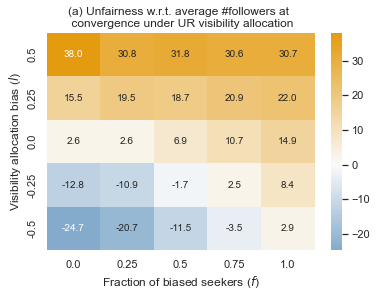

In [12]:
# generate the heatmap for UR (Figure 1a)
df_M1a = plots_M1('UR')

# use the line below instead if df_M1a was already generated
# df_M1a = plots_M1('UR', df = df_M1a)

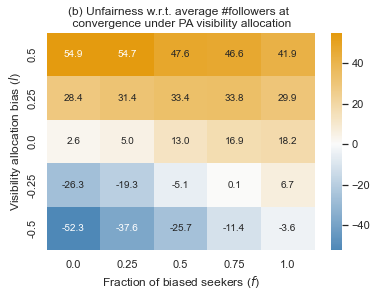

In [13]:
# generate the heatmap for PA (Figure 1b)
df_M1b = plots_M1('PA', 'b')

# use the line below instead if df_M1b was already generated
# df_M1b = plots_M1('PA', 'b', df = df_M1b)

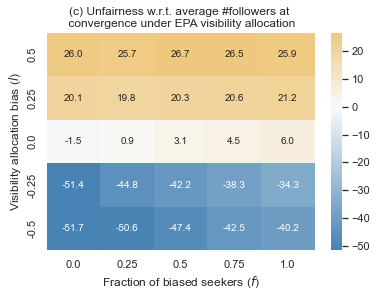

In [14]:
# generate the heatmap for ExtremePA (Figure 1c)
df_M1c = plots_M1('ExtremePA', 'c')

# use the line below instead if df_M1c was already generated
# df_M1c = plots_M1('ExtremePA', 'c', df = df_M1c)

### M2: Seekers’ biases impact top- and bottom-quality CCs differently

Using the auxiliary functions prsented at the beginning, we create the barplots corresponding to Figure 2. In turn, we present the code for showing how the fraction of biased users affects the average number of followers of different subgroups (Fig.2a), the level of bias of VAS affects the average number of followers of different subgroups (Fig.2b), and the effectiveness of reducing either the fraction of biased seekers or the level of bias in VAS (Fig.2c).

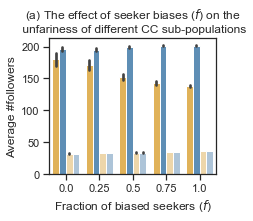

In [15]:
# Create Df for the barplot showing the effect of the fraction of biased seekers on the average #folowers
fp = {'rs_model': ['biased_PA'], 'cumulative_weights': ['[[1, 0], [0.5, 0.5]]'], "level_bias_RS":['0']}
df_M1_1_PA, colours_M1_1_PA = data_level_satisfaction(sims, fixed_pars = fp, 
                                                      x=['prob_cumulative_weights'], y='num_followers', 
                                                      hue_for = 'CCs', hue_classes = ['-33%', '33%-'],
                                                      print_progress = False)

# set plot size and style
sns.set(rc={'figure.figsize':(3,2.5)})
sns.set_theme(style="ticks")

# choose title, variables, labels and generatge the plot
title = '(a) The effect of seeker biases ($f$) on the\n unfariness of different CC sub-populations'
x1 = 'prob_cumulative_weights'
xs = [x1]
y = 'average_num_followers'
h = 'type'
labels = {x1: 'Fraction of biased seekers ($f$)', y: 'Average #followers', h: 'CC type'}
satisfaction_barplot(df_M1_1_PA, xs, y, h, labels, title, colours_M1_1_PA, True, include_legend = False)

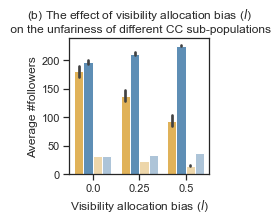

In [16]:
# Create Df for showing the effect of the VAS bias on the average #folowers
fp = {'rs_model': ['biased_PA'], 'cumulative_weights': ['[[1, 0], [0.5, 0.5]]'], 
      'prob_cumulative_weights':['[1, 0]'], "level_bias_RS":['0', '0.25', '0.5']}
df_M1_1b_PA, colours_M1_1b_PA = data_level_satisfaction(sims, fixed_pars = fp, 
                                                        x=['level_bias_RS'], y='num_followers', 
                                                        hue_for = 'CCs', hue_classes = ['-33%', '33%-'],
                                                        print_progress = False)

# set plot size and style
sns.set(rc={'figure.figsize':(2.5,2.5)})
sns.set_theme(style="ticks")

# choose title, variables, labels and generatge the plot
title = '(b) The effect of visibility allocation bias ($l$)\n on the unfariness of different CC sub-populations'
x1 = 'level_bias_RS'
xs = [x1]
y = 'average_num_followers'
h = 'type'
labels = {x1: 'Visibility allocation bias ($l$)', y: 'Average #followers', h: 'CC type'}
satisfaction_barplot(df_M1_1b_PA, xs, y, h, labels, title, colours_M1_1b_PA, True, include_legend = False)

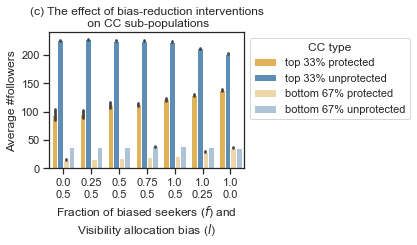

In [17]:
# create Df for the barplot showing the effect of reducing VAS biases and fraction of biased seekers
fp = {'rs_model': ['biased_PA'], 'cumulative_weights': ['[[1, 0], [0.5, 0.5]]'], "level_bias_RS":['0', '0.25', '0.5']}
df_M1_3_PA, colours_M1_3_PA = data_level_satisfaction(sims, fixed_pars = fp, 
                                                      x=['prob_cumulative_weights', "level_bias_RS"], 
                                                      y='num_followers', hue_for = 'CCs', 
                                                      hue_classes = ['-33%', '33%-'],
                                                      print_progress = False)

# rename the variables for the y axis and the hue
labels = {'average_num_followers': 'Average #followers', 'type': 'CC type'}
df_M1_3_PA.rename(columns = labels, inplace = True)

# make entries for x axis strings
df_M1_3_PA['level_bias_RS'] = df_M1_3_PA.apply(lambda r: ast.literal_eval(r['level_bias_RS']), axis = 1)
df_M1_3_PA['prob_cumulative_weights'] = df_M1_3_PA.apply(lambda r: ast.literal_eval(r.prob_cumulative_weights)[-1], axis = 1)

# create a new column with the combined values (for the x axis)
x = 'Fraction of biased seekers ($f$) and \nVisibility allocation bias ($l$)'
df_M1_3_PA[x] = df_M1_3_PA['prob_cumulative_weights'].astype(str) + '\n' + df_M1_3_PA['level_bias_RS'].astype(str)

# set plot size and style
sns.set(rc={'figure.figsize':(3.5,2.5)})
sns.set_theme(style="ticks")

# choose title, order of variables, and generatge the plot
title = '(c) The effect of bias-reduction interventions\n on CC sub-populations'
order_x = ['0.0\n0.5', '0.25\n0.5', '0.5\n0.5', '0.75\n0.5', '1.0\n0.5', '1.0\n0.25', '1.0\n0.0']
ax = sns.barplot(data=df_M1_3_PA, x='Fraction of biased seekers ($f$) and \nVisibility allocation bias ($l$)', 
                 y='Average #followers', hue = 'CC type', order = order_x, palette = colours_M1_3_PA)
ax.set_title(title)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### M3: Boosting the visibility of protected CCs could overcome seeker biases; however, outcomes are not fair with respect to all metrics

We again use the auxiliary functions, this time to test the effects of interventions. In order, the three blocks below look at the effeciency of a 25% level of visibility boost for protected contenet creators on the three metrics of interest: average number of followers (Fig.3a), average number of seekers recommended a content creator within the respective group (Fig.3b), and the average number of content creators within that group that achieved individually fair outcomes (Fig.3c).

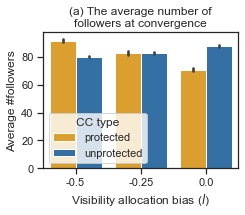

In [18]:
# create dataframe for the effect of visibility boosts on the average number of followers
fp = {'rs_model': ['biased_PA'], 'cumulative_weights': ['[[1, 0], [0.5, 0.5]]'], 
      'prob_cumulative_weights': ['[0.25, 0.75]'], "level_bias_RS":['0', '-0.25','-0.5']}
df_M3_followers = data_level_satisfaction(sims, fixed_pars = fp, x=["level_bias_RS"], y="num_followers", 
                                          hue_for = 'CCs', print_progress = False)[0]

# choose title, variables, labels and generatge the plot
title = '(a) The average number of\nfollowers at convergence'
x1 = 'level_bias_RS'
xs = [x1]
y = 'average_num_followers'
h = 'type'
labels = {x1: 'Visibility allocation bias ($l$)', y: 'Average #followers', h: 'CC type'}
satisfaction_barplot(df_M3_followers, xs, y, h, labels, title, first_time = True)

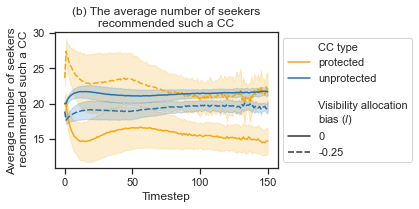

In [19]:
# create dataframe for the effect of visibility boosts on the chance of IF outcomes
fp = {'rs_model': ['biased_PA'], 'cumulative_weights': ['[[1, 0], [0.5, 0.5]]'], 
      'prob_cumulative_weights': ['[0.25, 0.75]'], "level_bias_RS":['0', '-0.25']}
df_M3_rec = data_level_satisfaction(sims, fixed_pars = fp, x=["level_bias_RS"], 
                                    y='num_users_recommended_CC', hue_for = 'CCs', 
                                    break_by_timestep = True, print_progress = False)[0]

# choose title, variables, and labels
title = '(b) The average number of seekers\nrecommended such a CC'
x = 'timestep'
y = 'average_num_users_recommended_CC'
h = 'type'
s = 'level_bias_RS'
labels = {s: '\nVisibility allocation\nbias ($l$)', y: 'Average number of seekers\n recommended such a CC', 
          h: 'CC type', x:'Timestep'}
df_M3_rec.rename(columns = labels, inplace = True)

# set the size and style of plot
sns.set(rc={'figure.figsize':(4,2.5)})
sns.set_theme(style="ticks")

# create the lineplot
palette ={"protected": '#f7a811', "unprotected": '#2272b5'}
df_aux_M3_rec = df_M3_rec[df_M3_rec['Timestep'] <=150]
ax = sns.lineplot(data=df_aux_M3_rec, x=labels[x], y=labels[y], ci='sd', hue=labels[h], style=labels[s], palette = palette)
ax.set_title(title)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

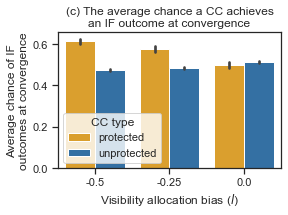

In [20]:
# create dataframe for the effect of visibility boosts on the visibility during recommendations
fp = {'rs_model': ['biased_PA'], 'cumulative_weights': ['[[1, 0], [0.5, 0.5]]'], 
      'prob_cumulative_weights': ['[0.25, 0.75]'], "level_bias_RS":['0', '-0.25','-0.5']}
df_M3_IF = data_level_satisfaction(sims, fixed_pars = fp, x=["level_bias_RS"], y='CC_is_IF', 
                                   hue_for = 'CCs', print_progress = False)[0]

# choose title, variables, labels and generatge the plot
title = '(c) The average chance a CC achieves\nan IF outcome at convergence'
x1 = 'level_bias_RS'
xs = [x1]
y = 'average_CC_is_IF'
h = 'type'
labels = {x1: 'Visibility allocation bias ($l$)', y: 'Average chance of IF\noutcomes at convergence', h: 'CC type'}
satisfaction_barplot(df_M3_IF, xs, y, h, labels, title, first_time = True)

### M4: Seekers also benefit from bias-reducing interventions

Finally, we produce the plots for the effect of biases and interventions on the unfairness for the seeker population. All plots are realised for PA visibility allocation systems. The upcomming blocks of code report the unfairness with respect to search time (Fig.4a), quality of recommendations (Fig.4b), and type of recommendation (Fig.4c).

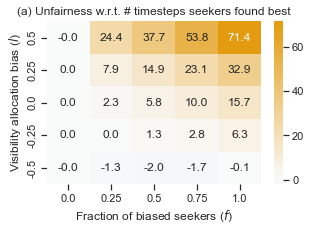

In [21]:
# set the size and style of plot
sns.set(rc={'figure.figsize':(4.8,3)})
sns.set_theme(style="ticks")

# create dataframe for search time
fp = {'rs_model': ['biased_PA'], 'cumulative_weights':['[[1, 0], [0.5, 0.5]]']}
df_M4a = create_df_unfairness(sims, fixed_pars = fp, x='level_bias_RS', 
                              y='prob_cumulative_weights', measure='num_timestep_users_found_best', 
                              measure_for = 'seekers', print_progress = False)

# choose title, variables, labels and generatge the plot
x = 'level_bias_RS'
y = 'prob_cumulative_weights'
m = 'unfairness_num_timestep_users_found_best'
labels = {x: 'Visibility allocation bias ($l$)', y: 'Fraction of biased seekers ($f$)', 
          m: '(a) Unfairness w.r.t. # timesteps seekers found best'}
plot_heatmap(df_M4a, x, y, m, labels, True)

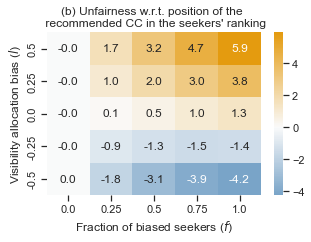

In [22]:
# create dataframe for the quality of recommendations
fp = {'rs_model': ['biased_PA'], 'cumulative_weights':['[[1, 0], [0.5, 0.5]]']}
df_M4b = create_df_unfairness(sims, fixed_pars = fp, x='level_bias_RS', 
                              y='prob_cumulative_weights', measure='users_pos_rec', 
                              measure_for = 'seekers', print_progress = False)


# choose title, variables, labels and generatge the plot
x = 'level_bias_RS'
y = 'prob_cumulative_weights'
m = 'unfairness_users_pos_rec'
labels = {x: 'Visibility allocation bias ($l$)', y: 'Fraction of biased seekers ($f$)', m: "(b) Unfairness w.r.t. position of the \n recommended CC in the seekers' ranking"}
plot_heatmap(df_M4b, x, y, m, labels, True)

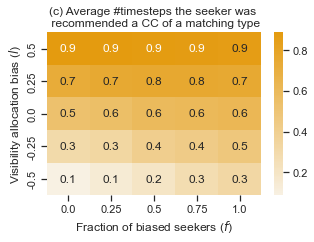

In [23]:
# create dataframe for the type of recommendations
fp = {'rs_model': ['biased_PA'], 'cumulative_weights':['[[1, 0], [0.5, 0.5]]']}
df_M4c = create_df_unfairness(sims, fixed_pars = fp, x='level_bias_RS', 
                              y='prob_cumulative_weights', measure='recommended_maching_CC', 
                              measure_for = 'seekers', print_progress = False)

# choose title, variables, labels and generatge the plot
x = 'level_bias_RS'
y = 'prob_cumulative_weights'
m = 'recommended_maching_CC'
labels = {x: 'Visibility allocation bias ($l$)', y: 'Fraction of biased seekers ($f$)', m: "(c) Average #timesteps the seeker was \n recommended a CC of a matching type"}
plot_heatmap(df_M4c, x, y, m, labels, True)